# I. Introduction

## A. Objective
The main objective of this analysis is to evaluate the performance of a random forest classifier model in predicting the mortality rate based on various features and to understand the importance of each feature in the model.
This research is a part of a series of trials of different ML models.

## B. Dataset Description
The dataset consists of the following features:
1. Age
1. HBR (b)
1. Systolic AP(b)
1. Creatine in blood
1. EF Percentage
1. White blood cells count
1. Glucose
1. CHF KiLLip_1.0
1. CHF KiLLip_2.0
1. CHF KiLLip_3.0
1. CHF KiLLip_4.0

# II. Import Necessary Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV
import shap

# III. Load Data

In [37]:
ready_data = pd.read_csv('./import/dataset_prepared_KiLLip_encoded.csv')

# IV. Splitting and processing the Data

## A. Splitting 

In [38]:
X_global = ready_data.drop('Class', axis=1)
y_global = ready_data['Class']

### An additional splitting to hold out a global test set

In [39]:
X_global_train, X_global_test, y_global_train, y_global_test = train_test_split(X_global, y_global, test_size=0.2, random_state=0, stratify=y_global)

We want to have more control over hyper parameters, so we examine three different random_state values. 

In [40]:
random_states = [0, 25, 42]

# V. Random Forest Classfier

## A. Initaial values

In [41]:
feature_names = ["Age", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", 
                 "White blood cells count", "Glucose", "CHF KiLLip_1.0", 
                 "CHF KiLLip_2.0", "CHF KiLLip_3.0", "CHF KiLLip_4.0"]

feature_importances = pd.DataFrame(index=feature_names)

best_score = 0  
best_params = {}
all_params = []

## B. Creating a grid with hyperparameters for grid search

In [42]:
hyperparameter_grid = {
    'n_estimators': [200, 250, 300, 350, 400], 
    'max_depth': [None, 2, 5, 7], 
    'min_samples_split': [5, 7, 10, 12],
    'min_samples_leaf': [4, 5, 6]
    }

A function to help us to evaluate models

In [43]:
def evaluate_model(y_test, y_predict_proba, threshold=0.5):
    """
    Evaluate a binary classification model using various metrics and plots.
    
    Parameters:
    -----------
    y_test : array-like of shape (n_samples,)
        True labels of the test set.
    y_predict_proba : array-like of shape (n_samples,)
        Probability estimates of the positive class.
    threshold : float, optional (default=0.5)
        Threshold for converting probability estimates to binary predictions.
    
    Returns:
    --------
    metrics : dict
        A dictionary containing the following metrics:
        - Precision
        - Recall
        - F1
        - F1_macro
        - ROC_AUC
        - PR_AUC
    
    Plots:
    ------
    - ROC curve
    - Precision-Recall curve
    """
    # Convert probability scores to binary predictions
    y_pred = (y_predict_proba >= threshold).astype(int)

    # 1. Precision, Recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # 2. F1-macro
    _, _, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    # 3. ROC-AUC
    roc_auc = roc_auc_score(y_test, y_predict_proba)


    # Create a figure to hold the subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # 4. Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")

    # 5. PR-AUC
    pr_auc = average_precision_score(y_test, y_predict_proba)

    # 6. Plot Precision-Recall curve
    precision_data, recall_data, _ = precision_recall_curve(y_test, y_predict_proba)
    axs[1].plot(recall_data, precision_data, color='b', alpha=0.2, label='PR curve (area = %0.2f)' % pr_auc)
    axs[1].fill_between(recall_data, precision_data, step='post', alpha=0.2, color='b')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_title('Precision-Recall curve')
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # Return metrics as a dictionary
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'F1_macro': f1_macro,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc
    }
    
    return metrics

## C. Chosing the best hyper parameters for the model on the train set

Due to imbalanced classes, we will use "average_precision" score as a main metric to evaluate models performance.

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


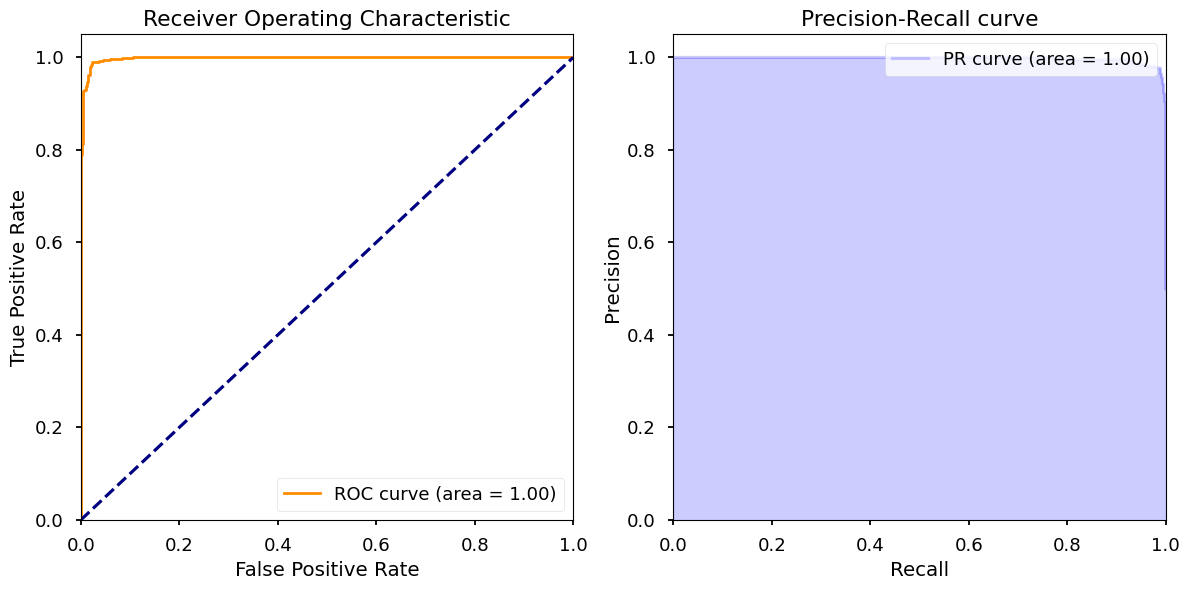

{'Precision': 0.6996996996996997,
 'Recall': 1.0,
 'F1': 0.823321554770318,
 'F1_macro': 0.7750487555272355,
 'ROC_AUC': 0.997734347657905,
 'PR_AUC': 0.9976797236342985}

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


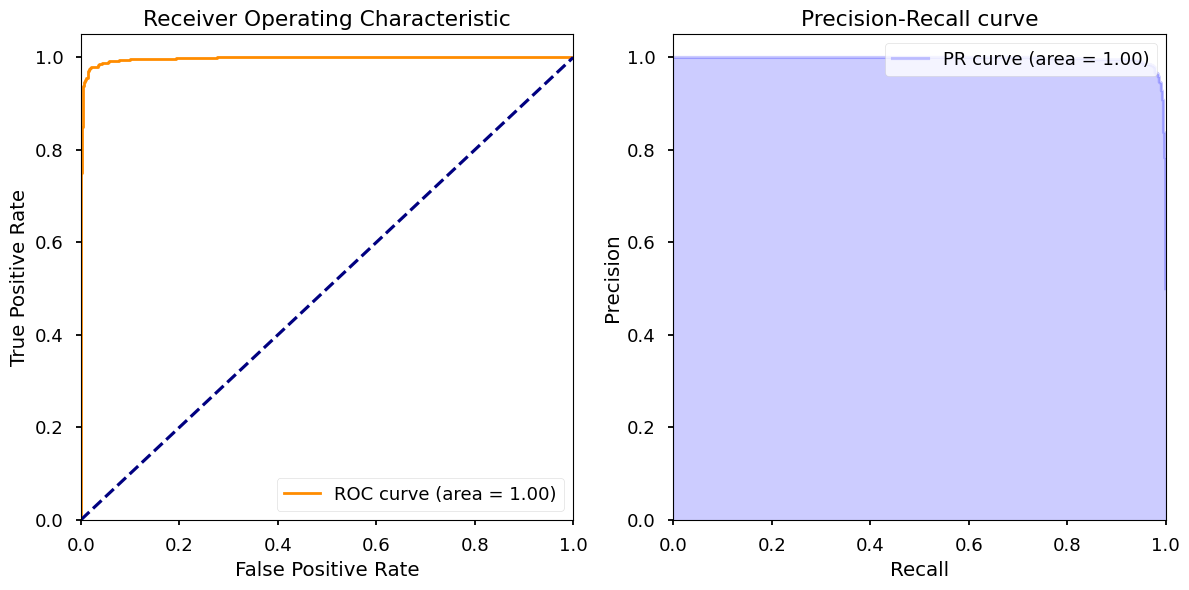

{'Precision': 0.7147239263803681,
 'Recall': 1.0,
 'F1': 0.8336314847942754,
 'F1_macro': 0.7921508630405694,
 'ROC_AUC': 0.9969330803661884,
 'PR_AUC': 0.9970691837539466}

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


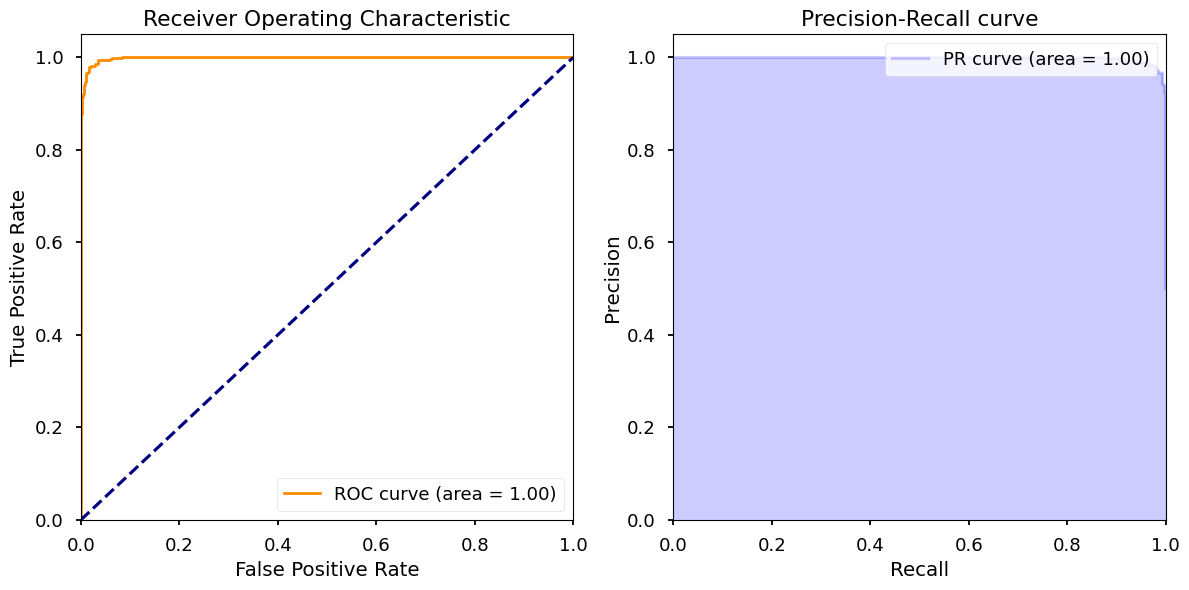

{'Precision': 0.7007518796992481,
 'Recall': 1.0,
 'F1': 0.8240495137046862,
 'F1_macro': 0.7762812370706241,
 'ROC_AUC': 0.9983836504632614,
 'PR_AUC': 0.9983898598018726}

,random_state,best_parameters,metrics
0,0,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}","{'Precision': 0.6996996996996997, 'Recall': 1.0, 'F1': 0.823321554770318, 'F1_macro': 0.7750487555272355, 'ROC_AUC': 0.997734347657905, 'PR_AUC': 0.9976797236342985}"
1,25,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}","{'Precision': 0.7147239263803681, 'Recall': 1.0, 'F1': 0.8336314847942754, 'F1_macro': 0.7921508630405694, 'ROC_AUC': 0.9969330803661884, 'PR_AUC': 0.9970691837539466}"
2,42,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}","{'Precision': 0.7007518796992481, 'Recall': 1.0, 'F1': 0.8240495137046862, 'F1_macro': 0.7762812370706241, 'ROC_AUC': 0.9983836504632614, 'PR_AUC': 0.9983898598018726}"


In [44]:
from imblearn.over_sampling import SMOTE

for random_state in random_states:

    # Split the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    # Resample
    
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_global_train, y_global_train)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state, stratify=y_resampled)

    # Define model
    model = RandomForestClassifier(random_state=random_state)

    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='average_precision',
                           verbose=1)
    
    # Execute grid search
    grid_cv.fit(X_train, y_train)

    y_predict_proba = grid_cv.predict_proba(X_test)[:, 1]

    threshold = 0.05
    metrics = evaluate_model(y_test, y_predict_proba, threshold)
    display(metrics)
    
    if grid_cv.best_score_ > best_score:
        best_score = grid_cv.best_score_
        best_params = {
            'random_state': random_state,
            'n_estimators': grid_cv.best_params_['n_estimators'],
            'max_depth': grid_cv.best_params_['max_depth'],
            'min_samples_split': grid_cv.best_params_['min_samples_split'],
            'min_samples_leaf': grid_cv.best_params_['min_samples_leaf'],
            'max_features': grid_cv.best_estimator_.max_features
        }

    all_params_entry = {
        'random_state': random_state,
        'best_parameters': grid_cv.best_params_,
        'metrics': metrics
    }
    all_params.append(all_params_entry)

all_params_df = pd.DataFrame(all_params)
pd.set_option('display.max_colwidth', None)
display(all_params_df)
    

## D. Retrain the model with the best parameters on the whole dataset

In [45]:
# Retrain the model with the best parameters
final_model = RandomForestClassifier(random_state=best_params['random_state'], 
                                n_estimators=best_params['n_estimators'], 
                                max_depth=best_params['max_depth'], 
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                max_features=best_params['max_features'],
                                n_jobs=-1)

smote = SMOTE(random_state=best_params['random_state'])
X_resampled, y_resampled = smote.fit_resample(X_global_train, y_global_train)

final_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_split=5, n_estimators=250, n_jobs=-1,
                       random_state=25)

## C. Evaluate final model

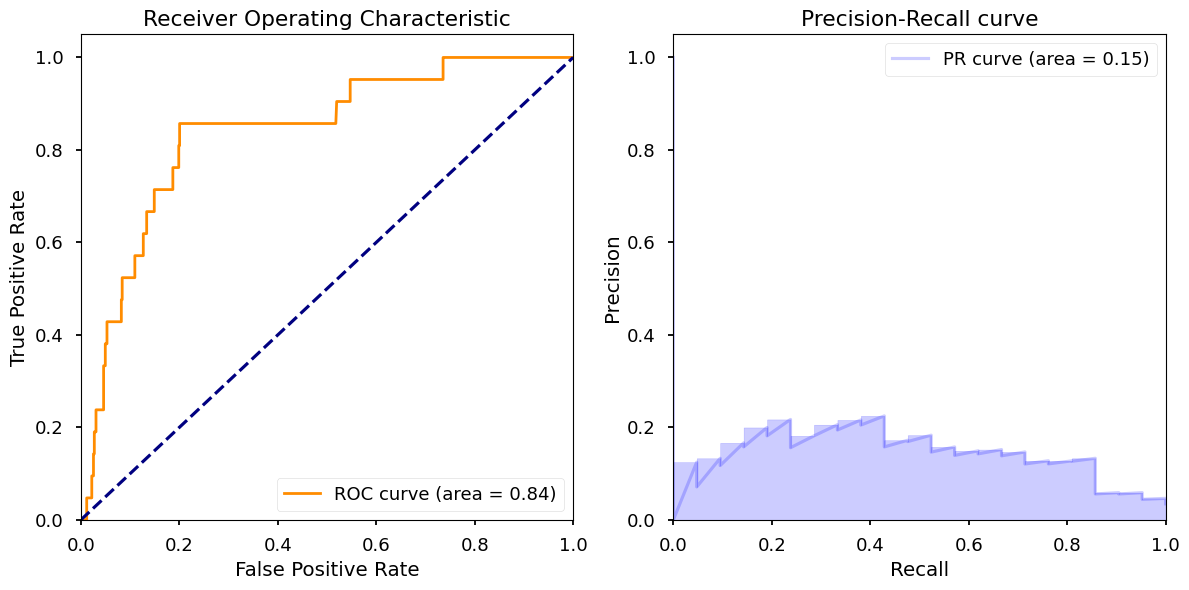

{'Precision': 0.05813953488372093,
 'Recall': 0.9523809523809523,
 'F1': 0.1095890410958904,
 'F1_macro': 0.3620305822324055,
 'ROC_AUC': 0.8386424895858857,
 'PR_AUC': 0.1517824167967284}

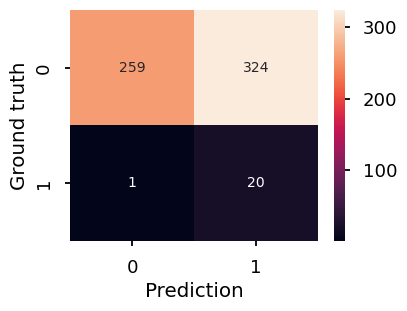

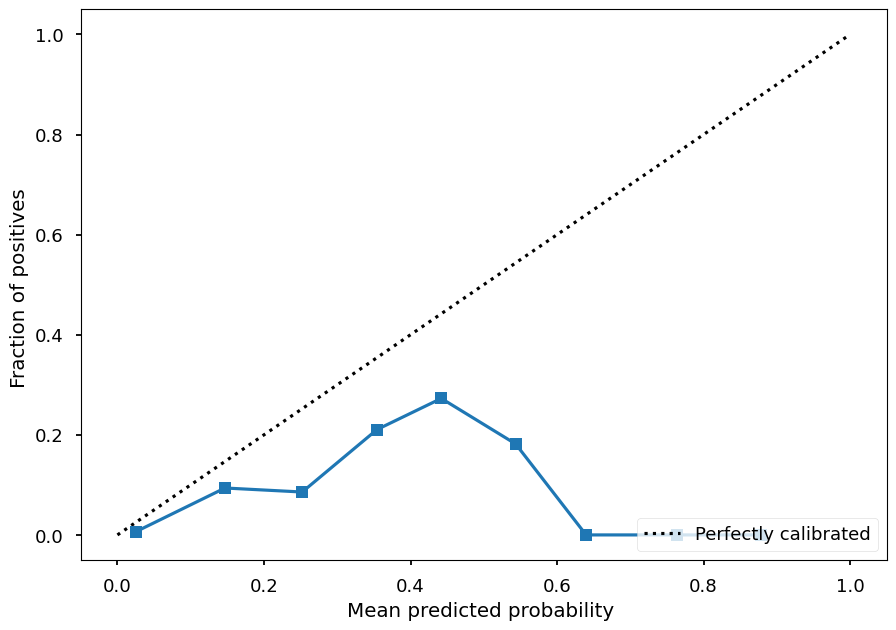

In [46]:
y_pred_proba = final_model.predict_proba(X_global_test)[:, 1]
threshold=0.02

metrics = evaluate_model(y_global_test, y_pred_proba, threshold)
display(metrics)

y_pred = (y_pred_proba >= threshold).astype(int)
cm = confusion_matrix(y_global_test, y_pred)
plt.figure(figsize = (4, 3))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Ground truth')
plt.xlabel('Prediction');

from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_global_test, y_pred_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_global_test)
disp.plot()

### Probability distribution

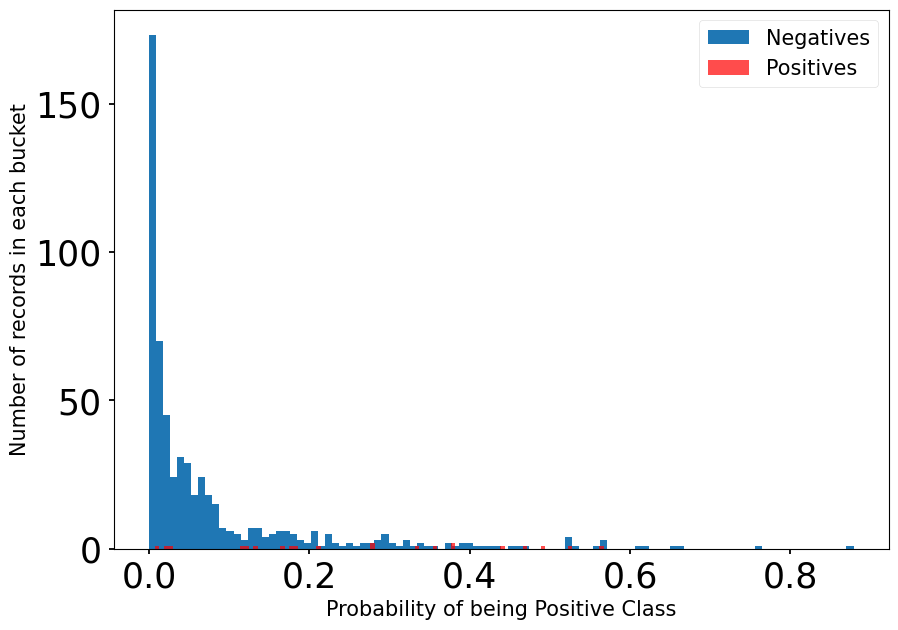

In [47]:
plt.figure(figsize=(10,7))
plt.hist(y_pred_proba[y_global_test==0], bins=100, label='Negatives')
plt.hist(y_pred_proba[y_global_test==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=15)
plt.ylabel('Number of records in each bucket', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

### 1. SHAP Values

In [48]:
explainer = shap.TreeExplainer(final_model, X_resampled)
shap_values = explainer.shap_values(X_global_test, check_additivity=False)

feature_importances["Feature importance"] = final_model.feature_importances_
feature_importances["Mean shap values"] = np.mean(np.abs(shap_values[1]), axis=0)

 99%|===================| 1190/1208 [00:41<00:00]        

### 2. Feature Importance Analysis

In [49]:
feature_importances

,Feature importance,Mean shap values
Age,0.047784,0.015434
HBR (b),0.103749,0.041092
Systolic AP(b),0.078523,0.032042
Creatinine in blood,0.093079,0.044008
EF Percentage,0.196087,0.091671
White blood cells count,0.057339,0.023842
Glucose,0.121865,0.046131
CHF KiLLip_1.0,0.185980,0.174073
CHF KiLLip_2.0,0.069975,0.066501
CHF KiLLip_3.0,0.035092,0.034195


### 3. Plotting features' weights and coefficients

In [50]:
def plot_weights(feature_importances, column1, column2, label1, label2, title, num_digits=3):
    plt.style.use('seaborn-v0_8-talk')  # Applying the style
    palette = sns.color_palette("husl", 2)  # Defining the color palette
    
    barWidth = 0.45

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create 1 row, 2 columns of subplots

    def add_values(ax, bars):
        for bar in bars:
            width = bar.get_width()
            if width >= 0:
                h_align = 'left'  # Horizontal alignment
                padding = 0.001  # Adjust this value to position the text to the right of the bar
            else:
                h_align = 'right' 
                padding = -0.000001  # Adjust this value to position the text to the left of the bar

            ax.text(width + padding,               
                    bar.get_y() + bar.get_height() / 2.5 ,  
                    f"{width :.{num_digits}f}",  
                    ha=h_align, va='center', fontsize=7)

    # Plot for column 1
    bars1 = axs[0].barh(r1, feature_importances[column1], color=palette[0], height=barWidth, edgecolor='grey', label=label1)
    axs[0].set_yticks(r1)
    axs[0].set_yticklabels(feature_importances.index, fontsize=10)
    axs[0].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)
    axs[0].legend()
    add_values(axs[0], bars1)  # Add values to the bars in the first subplot

    # Plot for column 2
    bars2 = axs[1].barh(r2, feature_importances[column2], color=palette[1], height=barWidth, edgecolor='grey', label=label2)
    axs[1].set_yticks(r2)
    axs[1].set_yticklabels(feature_importances.index, fontsize=10)
    axs[1].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[1].grid(axis='x', linestyle='--', alpha=0.7)
    axs[1].legend()
    add_values(axs[1], bars2)  # Add values to the bars in the second subplot

    # Set a common title
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top to make room for the suptitle

    plt.show()

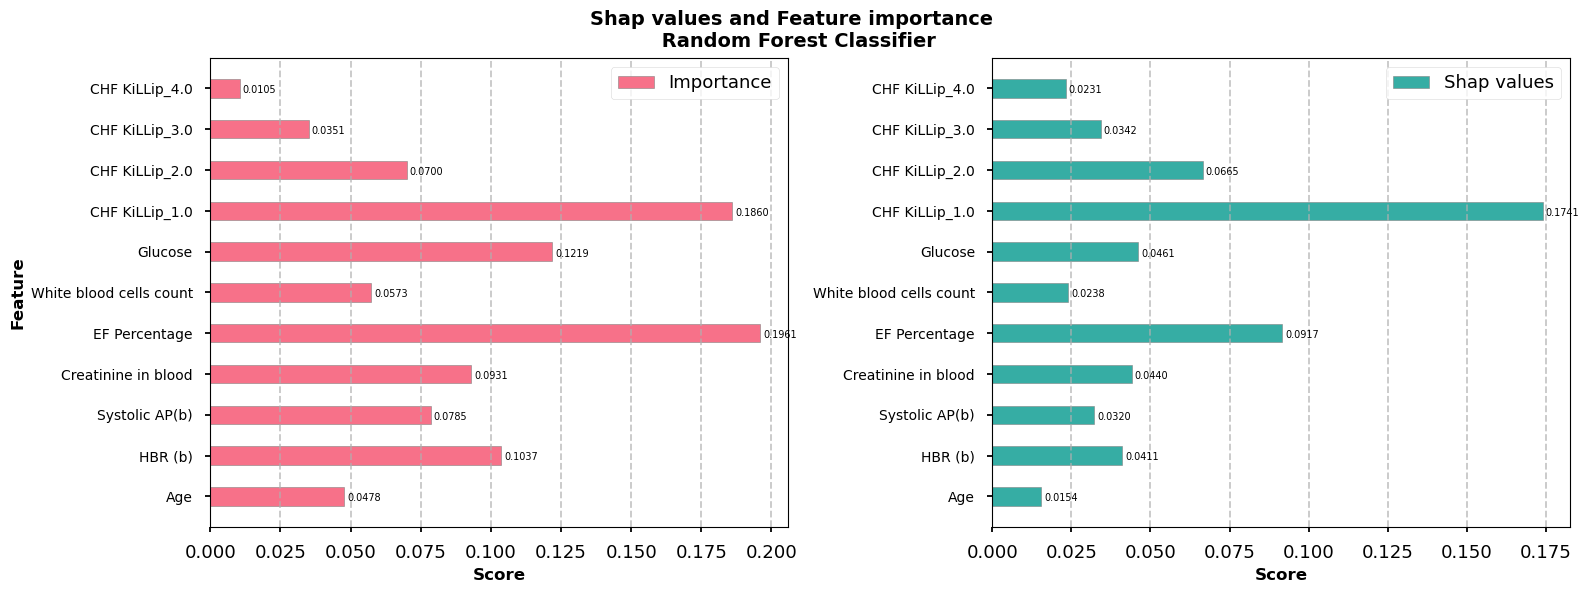

In [51]:
plot_weights(feature_importances, 
             'Feature importance',
             'Mean shap values', 
             label1='Importance', 
             label2='Shap values', 
             title='Shap values and Feature importance \n Random Forest Classifier', 
             num_digits = 4 )

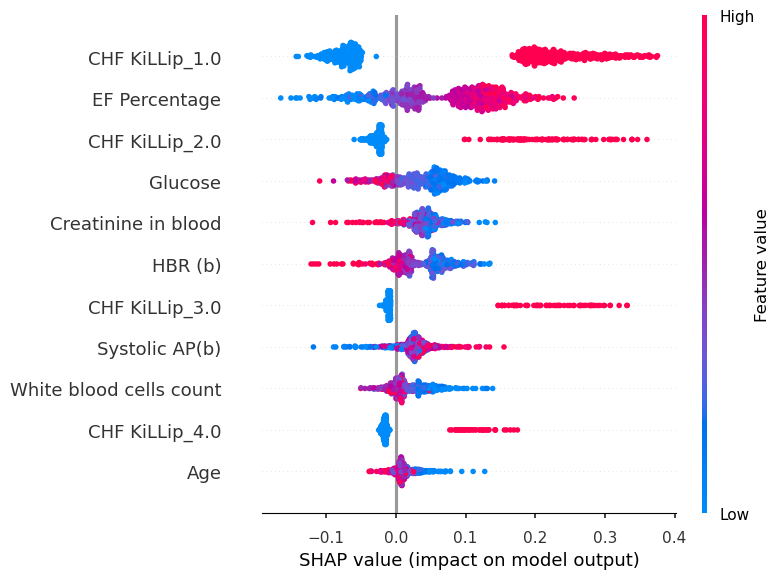

In [52]:
shap.summary_plot(shap_values[0], X_global_test, feature_names=feature_names, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)